In [1]:
import sys

# in order to import the modules located at the root directory
sys.path.append("..")

In [2]:
import logging
from importlib import reload  # Not needed in Python 2

reload(logging)
logging.basicConfig(
    format="%(message)s",
    level=logging.DEBUG,
)

LOGGER = logging.getLogger(__name__)

In [3]:
from mrs.dataset import SessionBuilder, PostDataset, PostDatasetCollator
from torch.utils.data import DataLoader

builder = SessionBuilder(style="formal")
post_dataset = PostDataset(builder)

post_dataloader = DataLoader(
    post_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=PostDatasetCollator(
        pad_idx=post_dataset.tokenizer.pad_token_id, max_length=99999
    ),
)

Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
Number of sessions: 236


In [4]:
batch = next(iter(post_dataloader))

In [5]:
LOGGER.info(f"Keys in the batch dictionary: {list(batch.keys())}")

Keys in the batch dictionary: ['mlm_inputs', 'urc_inputs']


## Roberta Model for MLM training

### model debugging

In [6]:
from transformers import AutoModel, AutoTokenizer, RobertaForMaskedLM, RobertaModel

# same as tokenizer in PostDataset
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")
special_tokens = {"sep_token": "<SEP>"}
tokenizer.add_special_tokens(special_tokens)

# ways to load roberta model
model_1 = RobertaForMaskedLM.from_pretrained("klue/roberta-base")
model_2 = RobertaModel.from_pretrained("klue/roberta-base")
model_3 = AutoModel.from_pretrained("klue/roberta-base")

# resize token embedding
model_1.resize_token_embeddings(len(post_dataset.tokenizer))
model_2.resize_token_embeddings(len(post_dataset.tokenizer))
model_3.resize_token_embeddings(len(post_dataset.tokenizer))

model_1.eval()
model_2.eval()
model_3.eval()

print("")

https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/config.json HTTP/1.1" 200 0
https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/config.json HTTP/1.1" 200 0
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/config.json HTTP/1.1" 200 0
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are resizing the embed

In [25]:
# in order to reconstruct the mask tokens, the dimentsion should be same as vocabulary size.
result_1 = model_1(batch["mlm_inputs"]["corrupt_tokens"], output_hidden_states=True)
print(result_1.keys())

odict_keys(['logits', 'hidden_states'])


In [26]:
print(result_1.logits.shape, result_1.hidden_states[-1].shape)

torch.Size([2, 101, 32001]) torch.Size([2, 101, 768])


In [27]:
result_2 = model_2(batch["mlm_inputs"]["corrupt_tokens"], output_hidden_states=True)
print(result_2.keys())

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])


In [31]:
print(result_2.last_hidden_state.shape)
print(result_2.pooler_output.shape)

torch.Size([2, 101, 768])
torch.Size([2, 768])


### train

In [6]:
import torch
import torch.nn as nn
from transformers import RobertaForMaskedLM


class PostTrainModel(nn.Module):
    def __init__(self, input_size):
        # defined in huggingface PreTrainedTokenizer
        # input_size = len(tokenizer) = tokenizer.vocab_size + len(tokenizer.added_tokens_encoder)

        super(PostTrainModel, self).__init__()
        self.model = RobertaForMaskedLM.from_pretrained("klue/roberta-base")
        self.model.resize_token_embeddings(input_size)

        hidden_size = self.model.config.hidden_size
        self.generator = nn.Linear(hidden_size, 3)

    def forward(
        self,
        corrupt_tokens,
        corrupt_mask_positions,
        mlm_attentions,
        urc_inputs,
        urc_attentions,
    ):
        # |corrupt_tokens| = (bs, length)
        # |corrupt_mask_positions| = List[Tensor]; Length(List)=bs
        # |mlm_attentions| = (bs, length)
        # |urc_inputs| = (bs*3, length)
        # |urc_attentions| = (bs*3, length)

        # forward for MLM
        corrupt_outputs = self.model(corrupt_tokens, attention_mask=mlm_attentions)[
            "logits"
        ]
        # |corrupt_outputs| = (bs, length, vocab_size)

        corrupt_mask_outputs = []
        for i, mask_position in enumerate(corrupt_mask_positions):
            corrupt_mask_output = []
            for pos in mask_position:
                corrupt_mask_output.append(corrupt_outputs[i, pos, :].unsqueeze(0))
                # |corrupt_outputs[i, pos, :].unsqueeze(0)| = (1, vocab_size)
            corrupt_mask_output = torch.cat(corrupt_mask_output, 0)
            # |corrupt_mask_output| = (n_masks, vocab_size)
            corrupt_mask_outputs.append(corrupt_mask_output)

        # forward for URC
        urc_outputs = self.model(
            urc_inputs, attention_mask=urc_attentions, output_hidden_states=True
        )["hidden_states"][-1]
        # |urc_outputs| = (bs*3, length, hidden_size)
        urc_logits = self.generator(urc_outputs)
        # |urc_logits| = (bs*3, length, 3)
        urc_cls_outputs = urc_logits[:, 0, :]
        # |urc_cls_outputs| = (bs*3, 3)

        return corrupt_mask_outputs, urc_cls_outputs

In [7]:
post_model = PostTrainModel(input_size=len(post_dataloader.dataset.tokenizer))

https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/config.json HTTP/1.1" 200 0
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [8]:
corrupt_mask_outputs, urc_cls_outputs = post_model(
    corrupt_tokens=batch["mlm_inputs"]["corrupt_tokens"],
    corrupt_mask_positions=batch["mlm_inputs"]["mask_positions"],
    mlm_attentions=batch["mlm_inputs"]["attention_masks"],
    urc_inputs=batch["urc_inputs"]["input_tokens"],
    urc_attentions=batch["urc_inputs"]["attention_masks"],
)

In [9]:
print(corrupt_mask_outputs[0].size())
print(corrupt_mask_outputs[1].size())
print(urc_cls_outputs.size())

torch.Size([5, 32001])
torch.Size([5, 32001])
torch.Size([6, 3])


In [10]:
from mrs.dataset import SessionBuilder, PostDataset, PostDatasetCollator
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup


def get_crit(pad_idx):
    crit = nn.CrossEntropyLoss(ignore_index=pad_idx)
    return crit


def get_optimizer(model, lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    return optimizer


# get dataloader
builder = SessionBuilder(style="formal")
post_dataset = PostDataset(builder)

post_dataloader = DataLoader(
    post_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=PostDatasetCollator(
        pad_idx=post_dataset.tokenizer.pad_token_id, max_length=99999
    ),
)

# initialize model
post_model = PostTrainModel(input_size=len(post_dataloader.dataset.tokenizer))

training_epochs = 5
max_grad_norm = 10
lr = 1e-5
n_training_steps = len(post_dataloader) * training_epochs
n_warmup_steps = len(post_dataloader)
crit = get_crit(pad_idx=post_dataloader.dataset.tokenizer.pad_token_id)
optimizer = get_optimizer(post_model, lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=n_training_steps
)

# load model, criterion to mps
post_model.to("mps:{}".format(0))
crit.to("mps:{}".format(0))

print("Initialization done.")

https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
Number of sessions: 236
https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/config.json HTTP/1.1" 200 0
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Initialization done.


In [ ]:
from tqdm import tqdm
import torch.nn.utils as torch_utils

loss_traces = []

for epoch in range(training_epochs):
    LOGGER.info(f"**** Training Epoch: {epoch} ****")

    # turn on train mode
    post_model.train()

    for i, batch in enumerate(tqdm(post_dataloader)):
        device = next(post_model.parameters()).device
        optimizer.zero_grad()

        mlm_inputs, urc_inputs = batch["mlm_inputs"], batch["urc_inputs"]

        mlm_corrupt_tokens, mlm_output_tokens, mlm_attention_masks = (
            mlm_inputs["corrupt_tokens"].to(device),
            mlm_inputs["output_tokens"].to(device),
            mlm_inputs["attention_masks"].to(device),
        )

        urc_input_tokens, urc_labels, urc_attention_masks = (
            urc_inputs["input_tokens"].to(device),
            torch.cat(urc_inputs["labels"], dim=0).to(device),
            urc_inputs["attention_masks"].to(device),
        )

        # forward model
        corrupt_mask_outputs, urc_cls_outputs = post_model(
            corrupt_tokens=mlm_corrupt_tokens,
            corrupt_mask_positions=mlm_inputs["mask_positions"],
            mlm_attentions=mlm_attention_masks,
            urc_inputs=urc_input_tokens,
            urc_attentions=urc_attention_masks,
        )
        mlm_mask_outputs = torch.cat(corrupt_mask_outputs, dim=0)

        # calculate mlm loss
        mlm_labels = []
        for i, mask_position in enumerate(mlm_inputs["mask_positions"]):
            org_token_indices = []
            for pos in mask_position:
                org_token_indices.append(mlm_output_tokens[i, pos].item())
            mlm_labels.extend(org_token_indices)
        mlm_labels = torch.tensor(mlm_labels).long().to(device)

        mlm_loss = crit(mlm_mask_outputs, mlm_labels)

        # calculate urc loss
        urc_loss = crit(urc_cls_outputs, urc_labels)

        # sum of mlm loss and urc loss
        total_loss = mlm_loss + urc_loss

        loss_traces += [total_loss.item()]

        # backward loss
        total_loss.backward()

        # clip gradient
        torch_utils.clip_grad_norm_(post_model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

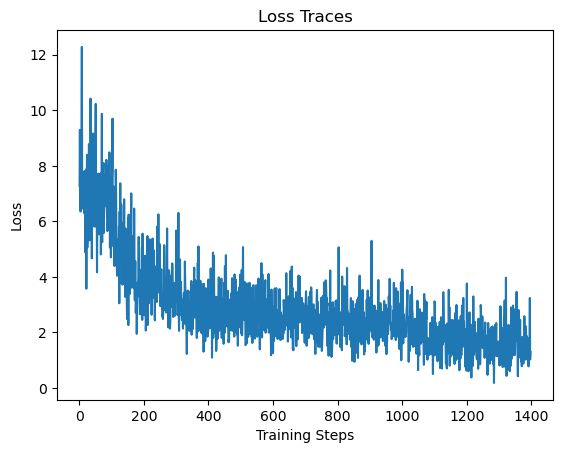

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List


def plot_loss(loss_traces: List):
    plt.plot(np.arange(1, len(loss_traces) + 1), loss_traces)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Loss Traces")
    plt.show()


plot_loss(loss_traces=loss_traces)

In [15]:
import os


def save_model(model, path):
    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(model.state_dict(), os.path.join(path, "post_model.bin"))


save_model(post_model, "../data")

In [17]:
post_model.load_state_dict(torch.load("../data/post_model.bin"))

<All keys matched successfully>